

## Dublin's Property Prices: A Spatial Perspective 🏠

 _By Cian Prendergast_ 

### **Introduction**

Much like its European counterparts, Dublin is experiencing a surge in house prices. My initial vision, sparked by [Shane Lynn's captivating geocoded visualization of Irish property prices](https://www.shanelynn.ie/the-irish-property-price-register-geocoded-to-small-areas/), was ambitious. While that precise visualization hasn't yet materialized, I've embarked on an exploration to generate longitude and latitude data from Irish addresses. Notably, these addresses don't include our newly minted Eircodes (akin to zip codes). A word of caution for the enthusiastic data enthusiast: tread carefully with APIs. A slip in my Google API usage nearly landed me with a €300 bill—thankfully, Google showed mercy!


### **Data Acquisition**

Original dataset collected via [Residential Property Price Register](https://www.propertypriceregister.ie/)

While this project used a subset dataset of 51,834 entries, covering Property Price Register from 2018, see [here](https://huggingface.co/datasets/c123ian/Dublin_House_Prices_2010_2022)  📊 to download all of Dublin prices from 2010 - 2022 from HuggingFace Hub. The [Residential Property Price Register](https://www.propertypriceregister.ie/) authority acknowledges that there may be errors in the data in the Register. The Register is compiled from data which is filed, for stamp duty purposes, with the Revenue Commissioners. The data is primarily filed electronically by persons doing the conveyancing of the property on behalf of the purchaser and errors may occur when the data is being filed.



Libraries that will be using: 


```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
import folium

import warnings
warnings.filterwarnings('ignore')
```


### **Initial Observations**

Upon loading our dataset, we made a few noteworthy observations:
- The dataset contains a total of 98,952 entries.
- Out of these, 68,224 entries lack a postal code.
- This means only 30,728 entries (or roughly 31%) include postal codes.

This data point is significant as postal codes can provide a granular view of property prices, allowing for more localized analyses.

### **Data Exploration**

Our dataset, stored in the file `DHP.csv`, is obtained from a shared Google Drive link. The data is then loaded into a Pandas DataFrame, a powerful tool for data analysis in Python.

```python
df = pd.read_csv('https://docs.google.com/uc?export=download&id=18ihnF-19iEhv9-vEfSz9-EmCfPqAnPQl', encoding= 'unicode_escape')
```

Let's take a quick glance at the first few rows of our dataset:

```python
df.head()
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Date of Sale</th>
      <th>Address</th>
      <th>Postal Code</th>
      <th>County</th>
      <th>Price</th>
      <th>Not Full Market Price</th>
      <th>VAT Exclusive</th>
      <th>Description of Property</th>
      <th>Property Size Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>02/09/2016</td>
      <td>114 Diswellstown Manor, Castleknock, Dublin 15</td>
      <td>Dublin 15</td>
      <td>Dublin</td>
      <td>541850.22</td>
      <td>No</td>
      <td>Yes</td>
      <td>New Dwelling house /Apartment</td>
      <td>greater than 125 sq metres</td>
    </tr>
    <tr>
      <th>1</th>
      <td>02/09/2016</td>
      <td>9 Dooroge Woods, Ballyboughal, Swords</td>
      <td>NaN</td>
      <td>Dublin</td>
      <td>189427.31</td>
      <td>No</td>
      <td>Yes</td>
      <td>New Dwelling house /Apartment</td>
      <td>greater than 125 sq metres</td>
    </tr>
    <tr>
      <th>2</th>
      <td>26/08/2016</td>
      <td>11 THE DRIVE, MILLERS GLEN, SWORDS</td>
      <td>NaN</td>
      <td>Dublin</td>
      <td>242246.00</td>
      <td>No</td>
      <td>Yes</td>
      <td>New Dwelling house /Apartment</td>
      <td>greater than 125 sq metres</td>
    </tr>
    <tr>
      <th>3</th>
      <td>26/08/2016</td>
      <td>57 Wellington Road, Templeogue</td>
      <td>Dublin 6w</td>
      <td>Dublin</td>
      <td>565000.00</td>
      <td>No</td>
      <td>Yes</td>
      <td>New Dwelling house /Apartment</td>
      <td>greater than 125 sq metres</td>
    </tr>
    <tr>
      <th>4</th>
      <td>25/08/2016</td>
      <td>1 Hollywoodrath Avenue, Hollystown, Dublin 15</td>
      <td>NaN</td>
      <td>Dublin</td>
      <td>290748.90</td>
      <td>No</td>
      <td>Yes</td>
      <td>New Dwelling house /Apartment</td>
      <td>greater than 125 sq metres</td>
    </tr>
  </tbody>
</table>
</div>

One of the first preprocessing steps we undertook was converting the 'Date of Sale' column to a datetime format, enabling time-based analyses. Additionally, we renamed certain columns for ease of access:

```python
df['Date of Sale'] = pd.to_datetime(df['Date of Sale'], dayfirst=True, format='%d/%m/%Y')
df = df.rename(columns={'Price (€)': 'Price'})
```




### **Data Cleaning**

Before any advanced analysis, it's paramount to ensure our dataset is clean and consistent. Data cleaning involves handling missing values, correcting anomalies, and structuring the data in a way that's conducive to analysis.

One of the first cleaning steps is to filter out entries that were not sold at the full market price and focus on properties that are either second-hand or new dwelling houses/apartments:

```python
df = df[df['Not Full Market Price'] == 'No']
df = df.drop('Not Full Market Price', axis=1)
df = df[(df['Description of Property'] == 'Second-Hand Dwelling house /Apartment') | 
        (df['Description of Property'] == 'New Dwelling house /Apartment')]
```

### **Longitude and Latitude Generation**

Before generating or refining spatial data, we prepared the dataset by creating empty columns for longitude (`long`) and latitude (`lat`). These columns will store the spatial coordinates for each property:


```python
df['long'] = ""
df['lat'] = ""
```

Before leveraging any geocoding service, it's essential to ensure that the columns intended to store the spatial data are of the appropriate data type. Here, we ensured that the latitude (`lat`) and longitude (`long`) columns could store floating-point numbers, allowing for the precision necessary in spatial coordinates:

```python
df["lat"] = pd.to_numeric(df["lat"], downcast="float")
df["long"] = pd.to_numeric(df["long"], downcast="float")
```

### **Enhancing Address Accuracy**

Accuracy is paramount when geocoding addresses. A slight variation or omission in an address can lead to a significantly different set of spatial coordinates. For instance, only 30,728 entries (or roughly 31%) include postal codes. To enhance the accuracy of our geocoding, we appended ", Dublin" to each address in our dataset. This ensures that the geocoding service understands the context and provides coordinates specific to Dublin:

```python
df['Address'] = df['Address'].apply(lambda x: "{}{}".format(x, ' , Dublin'))
```

## **Geocoding with the Google API**

With our dataset ready, we proceeded with geocoding each address using the [Google Maps API](https://developers.google.com/maps/documentation/geocoding/overview).

First, we set up the Google Maps client:

```python
import googlemaps
gmaps = googlemaps.Client(key='xxxxxx')  # Note: actual API key is masked for security reasons.
```

Then, for each address in our dataset, we sent a request to the Google Maps Geocoding API:

```python
for x in range(len(df)):
    try:
        geocode_result = gmaps.geocode(df['Address'][x])
        df['lat'][x] = geocode_result[0]['geometry']['location']['lat']
        df['long'][x] = geocode_result[0]['geometry']['location']['lng']
    except IndexError:
        print("Address was wrong...")
    except Exception as e:
        print("Unexpected error occurred.", e)
```

After the geocoding process, we saved the updated dataset with spatial coordinates:

```python
df.to_csv('output.csv', encoding='unicode_escape')
```


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Date of Sale</th>
      <th>Address</th>
      <th>Postal Code</th>
      <th>County</th>
      <th>Price</th>
      <th>VAT Exclusive</th>
      <th>Description of Property</th>
      <th>Property Size Description</th>
      <th>long</th>
      <th>lat</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>55590</th>
      <td>21/01/2010</td>
      <td>7 Hawthorn Terrace, Eastwall, Dublin , Dublin</td>
      <td>NaN</td>
      <td>Dublin</td>
      <td>210,000.0</td>
      <td>No</td>
      <td>Second-Hand Dwelling house /Apartment</td>
      <td>NaN</td>
      <td>-6.2375688552856445</td>
      <td>53.35382843017578</td>
    </tr>
    <tr>
      <th>55591</th>
      <td>21/01/2010</td>
      <td>76 Royston, Kimmage Road West, Dublin 12 , Dublin</td>
      <td>NaN</td>
      <td>Dublin</td>
      <td>297,500.0</td>
      <td>No</td>
      <td>Second-Hand Dwelling house /Apartment</td>
      <td>NaN</td>
      <td>-6.312779426574707</td>
      <td>53.315460205078125</td>
    </tr>
    <tr>
      <th>55592</th>
      <td>21/01/2010</td>
      <td>9 Woodstown Gardens, Ballycullen Road, Knockly...</td>
      <td>NaN</td>
      <td>Dublin</td>
      <td>409,000.0</td>
      <td>No</td>
      <td>Second-Hand Dwelling house /Apartment</td>
      <td>NaN</td>
      <td>-6.325483798980713</td>
      <td>53.275978088378906</td>
    </tr>
    <tr>
      <th>55593</th>
      <td>21/01/2010</td>
      <td>94, Loreto Avenue, Rathfarnham , Dublin</td>
      <td>Dublin 14</td>
      <td>Dublin</td>
      <td>271,000.0</td>
      <td>No</td>
      <td>Second-Hand Dwelling house /Apartment</td>
      <td>NaN</td>
      <td>-6.274948596954346</td>
      <td>53.28966522216797</td>
    </tr>
    <tr>
      <th>55594</th>
      <td>21/01/2010</td>
      <td>Apt. 49 Hunters Walk, Hunterswood, Ballycullen...</td>
      <td>NaN</td>
      <td>Dublin</td>
      <td>225,000.0</td>
      <td>No</td>
      <td>Second-Hand Dwelling house /Apartment</td>
      <td>NaN</td>
      <td>-6.3307037353515625</td>
      <td>53.27122497558594</td>
    </tr>
  </tbody>
</table>
</div>



### Visualizing the Spatial Distribution

To visualize the spatial distribution of the properties in our newly generated dataset, we can plot their latitude and longitude values:

```python
plt.figure(figsize=(10,10))
sns.jointplot(x=df.lat.values, y=df.long.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()
```

This visualization offers a bird's-eye view of the property distribution across Dublin. It can also help in identifying any outliers or anomalies in our geocoded data.

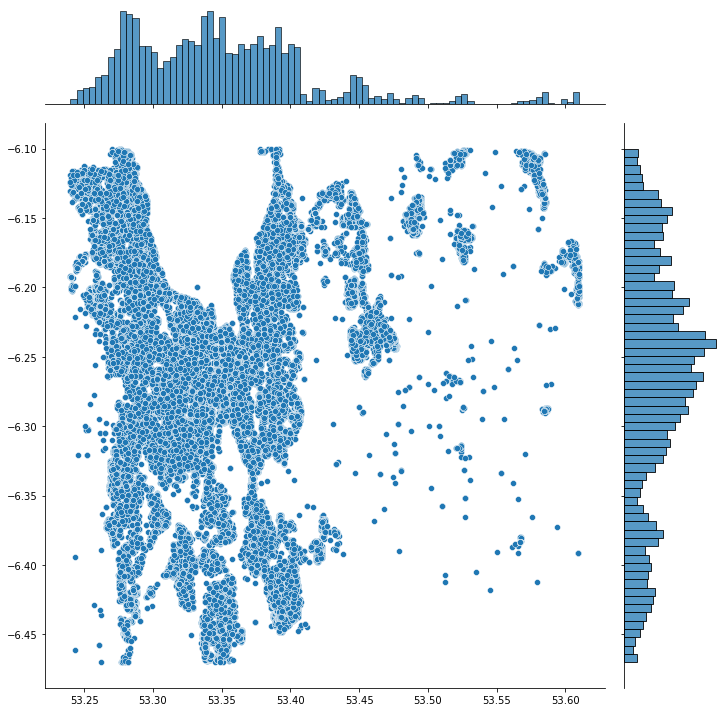

We can remove outliers [based on the percentiles](https://stackoverflow.com/questions/67629499/data-cleaning-of-lat-long-coordinates), repeat by generating the visulisation (we want our datapoints to be within the boundary/shape of Dublin.

```python
df[['long', 'lat']].describe(percentiles=[.01,.05,.1,.25,.5,.9,.95,.99]) # maybe dipslay by two decomal point
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>long</th>
      <th>lat</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>55526.00</td>
      <td>55526.00</td>
    </tr>
    <tr>
      <th>mean</th>
      <td>-6.29</td>
      <td>53.33</td>
    </tr>
    <tr>
      <th>std</th>
      <td>1.89</td>
      <td>0.67</td>
    </tr>
    <tr>
      <th>min</th>
      <td>-121.95</td>
      <td>-35.91</td>
    </tr>
    <tr>
      <th>1%</th>
      <td>-6.47</td>
      <td>53.24</td>
    </tr>
    <tr>
      <th>5%</th>
      <td>-6.44</td>
      <td>53.26</td>
    </tr>
    <tr>
      <th>10%</th>
      <td>-6.41</td>
      <td>53.28</td>
    </tr>
    <tr>
      <th>25%</th>
      <td>-6.32</td>
      <td>53.30</td>
    </tr>
    <tr>
      <th>50%</th>
      <td>-6.26</td>
      <td>53.34</td>
    </tr>
    <tr>
      <th>90%</th>
      <td>-6.15</td>
      <td>53.44</td>
    </tr>
    <tr>
      <th>95%</th>
      <td>-6.13</td>
      <td>53.49</td>
    </tr>
    <tr>
      <th>99%</th>
      <td>-6.10</td>
      <td>53.61</td>
    </tr>
    <tr>
      <th>max</th>
      <td>146.91</td>
      <td>56.44</td>
    </tr>
  </tbody>
</table>
</div>



### **Basic Folium Map**

We `import folium` and use our dataset mean to help follium find Dublin. 

```python

map1 = folium.Map(
    # lat, long
    location=[53.34,-6.27],
    # use default OpenStreetMap title
    zoom_start=12,
)
df.apply(lambda row:folium.Circle(location=[row["lat"], row["long"]]).add_to(map1), axis=1)
map1

```
Add some colour scale using `LinearColormap` class. It gives us the ability to assign a color to the Circle objects added to our map:

```python
center = get_center_latlong(df3)

# create a LinearColorMap and assign colors, vmin, and vmax
# the colormap will show green for $100,000 homes all the way up to red for $1,500,000 homes
colormap = cm.LinearColormap(colors=['green', 'yellow', 'red'], vmin=230000, vmax=460000) # price range 25% and 75% quartile for 2018 - 2020

# create our map again.  This time I am using a different tileset for a new look
m = folium.Map(location=center, zoom_start=10, tiles='Stamen Toner')

# Same as before... go through each home in set, make circle, and add to map.
# This time we add a color using price and the colormap object
for i in range(len(df3)):
    folium.Circle(
        location=[df3.iloc[i]['lat'], df3.iloc[i]['long']],
        radius=10,
        fill=True,
        color=colormap(df3.iloc[i]['Price']),# colour by price
        fill_opacity=0.2
    ).add_to(m)

# the following line adds the scale directly to our map
m.add_child(colormap)

# Save map 
m.save('price_colormap.html')

m # to display

```

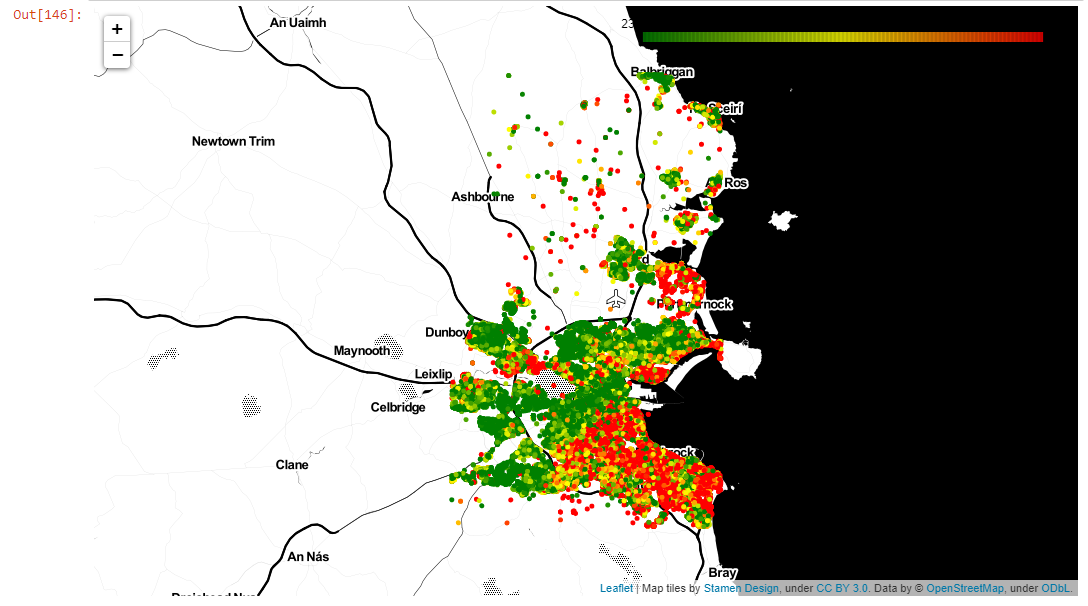


### **Segmenting the Map into Parishes using GeoJSON**

Dublin is divided into numerous parishes. Segmenting our data by these parishes allows us to understand property prices at a more localized level. The segmentation process involves:

1. **Obtaining Parish Boundaries**: This involves sourcing a map that clearly defines the boundaries of each parish.
2. **Overlaying Property Data**: Once we have the boundaries, we overlay our property data, ensuring each property is correctly located within its respective parish.
3. **Aggregating Data**: For each parish, we can now aggregate data, calculating metrics like average price, highest sale, and more.

Dublin parish boundaries in GeoJSON format, originally pulled from the 2011 Census, see source [here](https://github.com/ihuston/dublin_parishes). GeoJSON is a data format tailored for encoding geographical structures, extending the simplicity of JSON to spatial data. It uses polygons to represent the enclosed parish areas.

```python
dublin_map = folium.Map(location=[53.3302,  -6.3106],zoom_start= 11)
url = ("https://raw.githubusercontent.com/ihuston/dublin_parishes/master/data/cleaned_dublin_parishes.geojson")
dublin_parishes_edge = f"{url}"

f = folium.Choropleth(
    geo_data= dublin_parishes_edge,
    data = parish,
    columns=["parishes_name","Price"],
    key_on="feature.properties.Parish Name",
    name="choropleth",
    bins = 8,
    fill_color = "BuPu",
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight=True
).add_to(dublin_map)

f.geojson.add_child(
    folium.features.GeoJsonTooltip(['Parish Name'],labels=False)
)
dublin_map
```

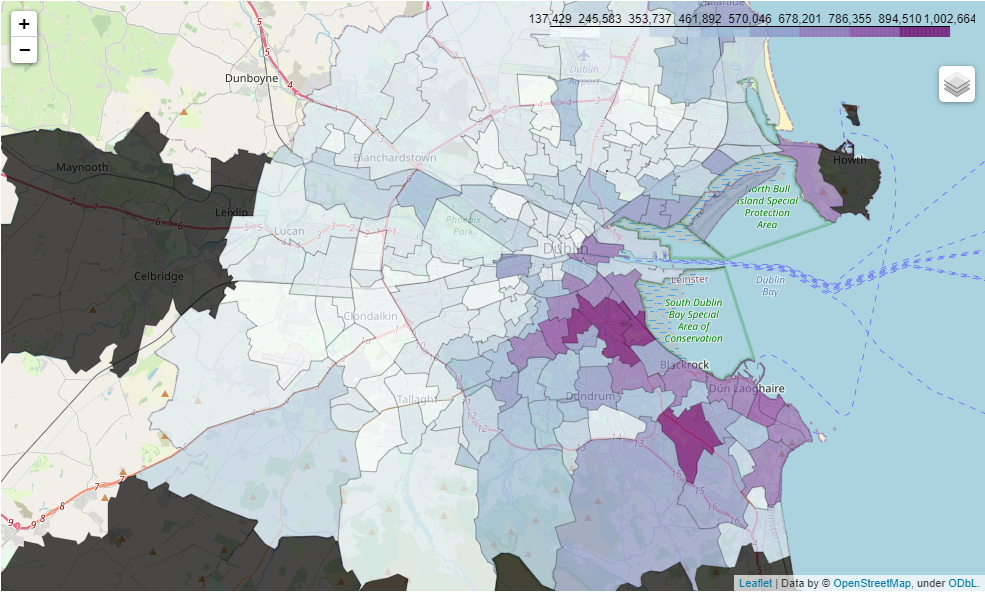

--------------------

### **Future Steps: Deepening the Analysis**

With our geocoded data ready and refined, we can deepen our analysis. Potential directions include:

1. **Spatial Clustering**: Grouping properties based on their spatial proximity can help identify hotspots or areas with similar price trends.
2. **Time-based Analysis**: Exploring how property prices have evolved over time, combined with the spatial data, can offer insights into emerging real estate trends in specific areas.
3. **Incorporating External Data**: Overlaying our property data with other datasets, like amenities, public transport routes, or school districts, can help identify factors influencing property prices.



### **Conclusion**

Spatial analysis, especially when combined with segmentation like parishes, provides a depth of insight that's hard to achieve otherwise. It allows stakeholders to make decisions based on localized trends rather than broad strokes. As we've showcased in this analysis, the value of such a project isn't just in the data, but in the nuanced understanding it provides.


 local version `<iframe src="file:///C:/Users/Cian/Documents/DCU/YEAR1/Data%20Mining%20CA683/price_colormap.html" width="100%" height="600"></iframe>
`


<iframe src="file:///C:/Users/Cian/Documents/DCU/YEAR1/Data%20Mining%20CA683/price_colormap.html" width="100%" height="600"></iframe>
